In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        A = np.zeros(len(Q[observation]), dtype=float)
        # We assign 100% action probability for the max-value action
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """

    # We use this for averaging when calculating Q
    returns_count = defaultdict(float)

    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i + 1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(i+1, num_episodes), end="")
            sys.stdout.flush()

        # The very first state(== observation)        
        observation = env.reset()

        # Keep track of all the state-actions visited in this episode
        # to update their Q values accordingly
        stateactions_visited = []

        # Unlike my on-policy versions, let's try calculating returns
        # after done with the episode.
        reward_history = []

        # We are naively assuming finite lengths of episodes here.
        # Using while loop like this might lead to infinite loop
        # depending on environments. Adding measures to enforce
        # finite number of iterations might be useful.
        episode_finished = False
        
        while not episode_finished:
            # Select the next action given the current state
            # Note: We are using behavior_policy() instead of target_policy()
            action = np.random.choice(env.action_space.n, p=behavior_policy(observation))
            
            # If taking this state-action is not possible at all under target_policy,
            # further progression of this episode is meaningless. Throw away this episode.
            if target_policy(observation)[action] == 0:
                episode_finished = True
                stateactions_visited[:] = []
            else:
                # Record the current state-action
                stateactions_visited.append((observation, action))

                # Record the result of the action
                observation, reward, done, _ = env.step(action)

                # Record the reward obtained from the action
                reward_history.append(reward)
                
                if done:
                    # If we receive 'done' signal, let's finish up the episode
                    episode_finished = True

        for j, stateaction in enumerate(stateactions_visited):
            # importance_sampling measures the similarity between policies.
            # We will be multiplying corrections to importance_sampling
            # for every state-actions (after the current `stateaction` in 
            # `stateactions_visited`)
            importance_sampling = 1.0
            returns_count[stateaction] += 1
            
            for sa in stateactions_visited[j:]:
                importance_sampling *= target_policy(sa[0])[sa[1]] / behavior_policy(sa[0])[sa[1]]

            # Updating the Q-values. Note that we are using incremental means and importance_sampling. 
            Q[stateaction[0]][stateaction[1]] += (1 / returns_count[stateaction]) * importance_sampling * (
                sum(
                    [
                        (reward * (discount_factor ** k)) 
                        for k, reward in enumerate(reward_history[j:])
                    ]
                ) 
                - Q[stateaction[0]][stateaction[1]]
            )

    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

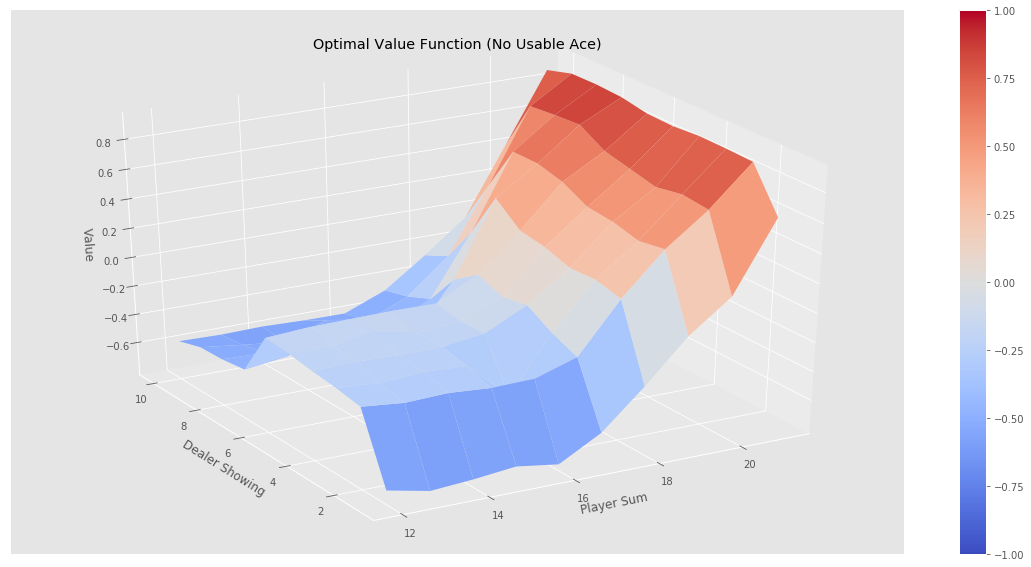

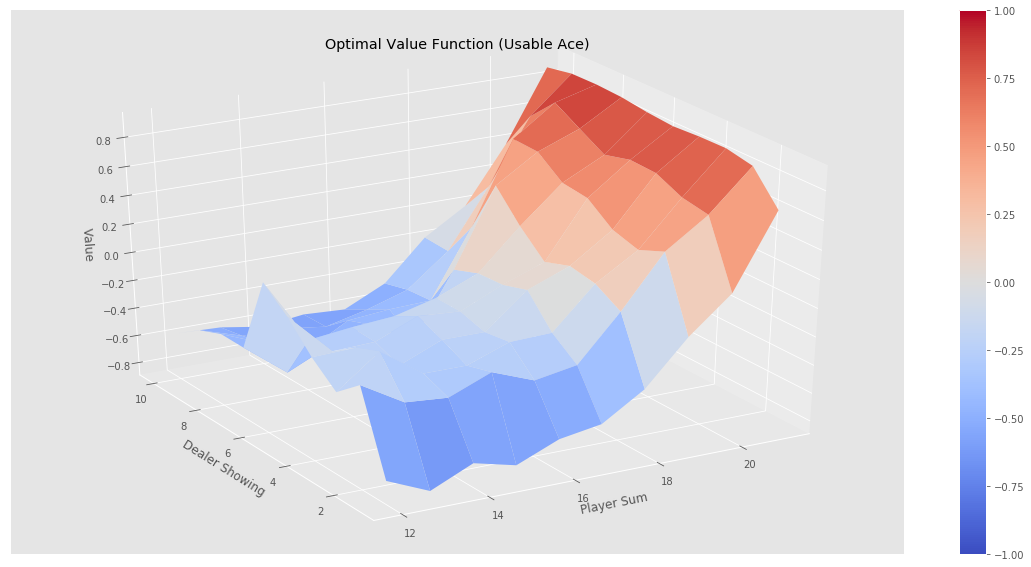

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")